# Tourament Predictor

Now, we are gonna predict the results for each game in the tourament and print the results in a pdf or png format.

**Steps**

(1) Import Train & Test Sets and combine with Kenpom data

(2) Prepare sets for model training

(3) Apply a Gradient Boosting Algorithm to predict the win probility of each potential game

(4) Apply predictions to a bracket creator script that runs in R

## Import Packages

In [234]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss, accuracy_score
from tqdm.notebook import tqdm
import glob
import os
import gc
from rpy2 import robjects
import PyPDF2
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,40)

## Set Path, Import Datasets, & Merge with Kenpom

Make sure to update the PATH to wherever your files are located

In [235]:
# Set Path
PATH = ''
os.chdir(PATH)

# Loading Datasets
train = pd.read_csv("inputs/tourney.csv")
test = pd.read_csv('inputs/test.csv')
kenpom = pd.read_csv('inputs/kenpom.csv')
kenpom = kenpom.drop(['team'],axis = 1)

In [236]:
# Merging train with Kenpom
train = train.merge(kenpom, how='left', left_on=['Season','TeamID1'],right_on=['year','teamid_x'])
train = train.merge(kenpom, how='left', left_on=['Season','TeamID2'],right_on=['year','teamid_x'])
train = train.drop_duplicates()
train.head()

,Season,TeamID1,TeamID2,result,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,...,luck_rank_y,sos_pyth_y,sos_pyth_rank_y,sos_oppo_y,sos_oppo_rank_y,sos_oppd_y,sos_oppd_rank_y,ncsos_pyth_y,ncsos_pyth_rank_y,teamid_x_y
0,2003,1421,1411,1,0.125000,1.00,0.833333,0.448276,0.333333,0.75,...,75,-12.96,321,94.4,322,107.4,314,-8.09,308,1411.0
16,2003,1112,1436,1,0.916667,0.00,0.933333,0.892857,0.500000,0.60,...,119,-5.14,251,99.3,249,104.4,245,-2.29,213,1436.0
17,2003,1113,1272,1,0.400000,0.50,0.800000,0.620690,0.636364,1.00,...,151,4.83,84,103.4,133,98.6,54,3.33,81,1272.0
18,2003,1141,1166,1,0.642857,1.00,0.916667,0.793103,0.636364,1.00,...,99,-0.19,155,102.5,159,102.7,168,-0.51,164,1166.0
22,2003,1143,1301,1,0.636364,0.25,0.928571,0.724138,0.300000,0.50,...,223,8.48,34,106.9,22,98.4,49,-6.48,292,1301.0


In [237]:
# Merging test with Kenpom
test = test.merge(kenpom, how='left', left_on=['Season','TeamID1'],right_on=['year','teamid_x'])
test = test.merge(kenpom, how='left', left_on=['Season','TeamID2'],right_on=['year','teamid_x'])
test = test.drop_duplicates()
test.head()

,ID,Season,TeamID1,TeamID2,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,...,luck_rank_y,sos_pyth_y,sos_pyth_rank_y,sos_oppo_y,sos_oppo_rank_y,sos_oppd_y,sos_oppd_rank_y,ncsos_pyth_y,ncsos_pyth_rank_y,teamid_x_y
0,2021_1101_1104,2021,1101,1104,0.555556,1.0,1.0,0.826087,0.700000,0.714286,...,107,14.20,27,109.7,28,95.5,32,8.88,70,1104.0
4,2021_1101_1111,2021,1101,1111,0.555556,1.0,1.0,0.826087,0.363636,1.000000,...,52,-2.97,232,100.1,249,103.1,221,5.72,113,1111.0
8,2021_1101_1116,2021,1101,1116,0.555556,1.0,1.0,0.826087,0.555556,0.500000,...,57,11.19,60,108.2,56,97.0,69,-5.28,282,1116.0
12,2021_1101_1124,2021,1101,1124,0.555556,1.0,1.0,0.826087,0.875000,0.800000,...,69,9.57,78,106.4,90,96.9,66,-4.18,270,1124.0
16,2021_1101_1140,2021,1101,1140,0.555556,1.0,1.0,0.826087,0.777778,0.600000,...,84,10.28,73,107.8,64,97.5,82,8.69,73,1140.0


## Prep Data For Model Training

In [238]:
# Setting X & Y for test
y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result','teamid_x_y'], axis=1)


X_test = test.drop(['ID', 'Season','TeamID1','TeamID2','teamid_x_y'], axis=1)



In [239]:
# Shaping data
train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

(2230,)

## Train and Execute Model

We are gonna train a Gradient Boosting Algorithm from sklearn. It is Histogram-based Gradient Boosting Classification Tree.

Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. 

The objective of Gradient Boosting classifiers is to minimize the loss, or the difference between the actual class value of the training example and the predicted class value. 

In [240]:
# Setting Model Parameters
NUM_FOLDS = 10
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

# Training and running model predictions
for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        
        
        model = HistGradientBoostingClassifier(max_iter=max_iter, validation_fraction=None, learning_rate=0.01, max_depth=2, min_samples_leaf=32)
        

        model =  model.fit(train_df, train_target)
        temp_oof = model.predict_proba(val_df)[:,1]
        temp_test = model.predict_proba(X_test)[:,1]

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))

0.4292334363415474
0.47525227469372716
0.5149112457231706
0.48030680082038757
0.5005102753812641
0.551239668445431
0.4730464558176283
0.4895087440648799
0.4673646702328737
0.4819779205547785



## Evaluate Model Performance Measures

In [241]:
# Evaluating Log Loss and Accuracy
y_preds = model.predict(X)
loss = log_loss(y, train_oof)
acc = accuracy_score(y,y_preds)

print("Logg Loss:", f'{loss:,.2f}')
print("\nAccuracy Score:", f'{acc:,.2f}')

Logg Loss: 0.49

Accuracy Score: 0.79


The model performance is pretty good. An accuracy score of 80% is very high and the log loss is relatively low as well. Next we are gonna export the predictions for 2021 and see how the bracket looks!

In [242]:
# Saving Probabilities
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

## Export Kaggle Submission File

In [243]:
# Reading in 2021 data
test = pd.read_csv('inputs/test.csv')
MSampleSubmission = pd.read_csv('inputs/MSampleSubmissionStage2.csv')

In [244]:
# Shaping Predictions for submission file
idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub.to_csv('outputs/submission2.csv', index=False)
sub.head()


,ID,Pred
0,2021_1101_1104,0.084620
1,2021_1101_1111,0.644588
2,2021_1101_1116,0.103511
3,2021_1101_1124,0.083395
4,2021_1101_1140,0.110173


## Export Predictions to Bracket PDF

- Executing R Script to print Bracket PDF
- Requires R to be installed on you machine
- Update PATH manually in png and pdf files below

In [245]:
robjects.r('''
...            #! /usr/bin/Rscript
...            png('/PATH/outputs/bracket_results.png')
...            library(collegehoops)
...            options(repr.plot.width = 50, repr.plot.height = 40)
...            bracket = collegehoops::parse_bracket('/Users/matthewdenko/Documents/march_madness_2021/outputs/submission2.csv', year = '2021')
...            collegehoops::print_bracket(bracket)
...            dev.off()         
''')

robjects.r('''
...            #! /usr/bin/Rscript
...            pdf('/PATH/outputs/bracket_results.pdf')
...            library(collegehoops)
...            options(repr.plot.width = 50, repr.plot.height = 40)
...            bracket = collegehoops::parse_bracket('/Users/matthewdenko/Documents/march_madness_2021/outputs/submission2.csv', year = '2021')
...            collegehoops::print_bracket(bracket)
...            dev.off()         
''')

1


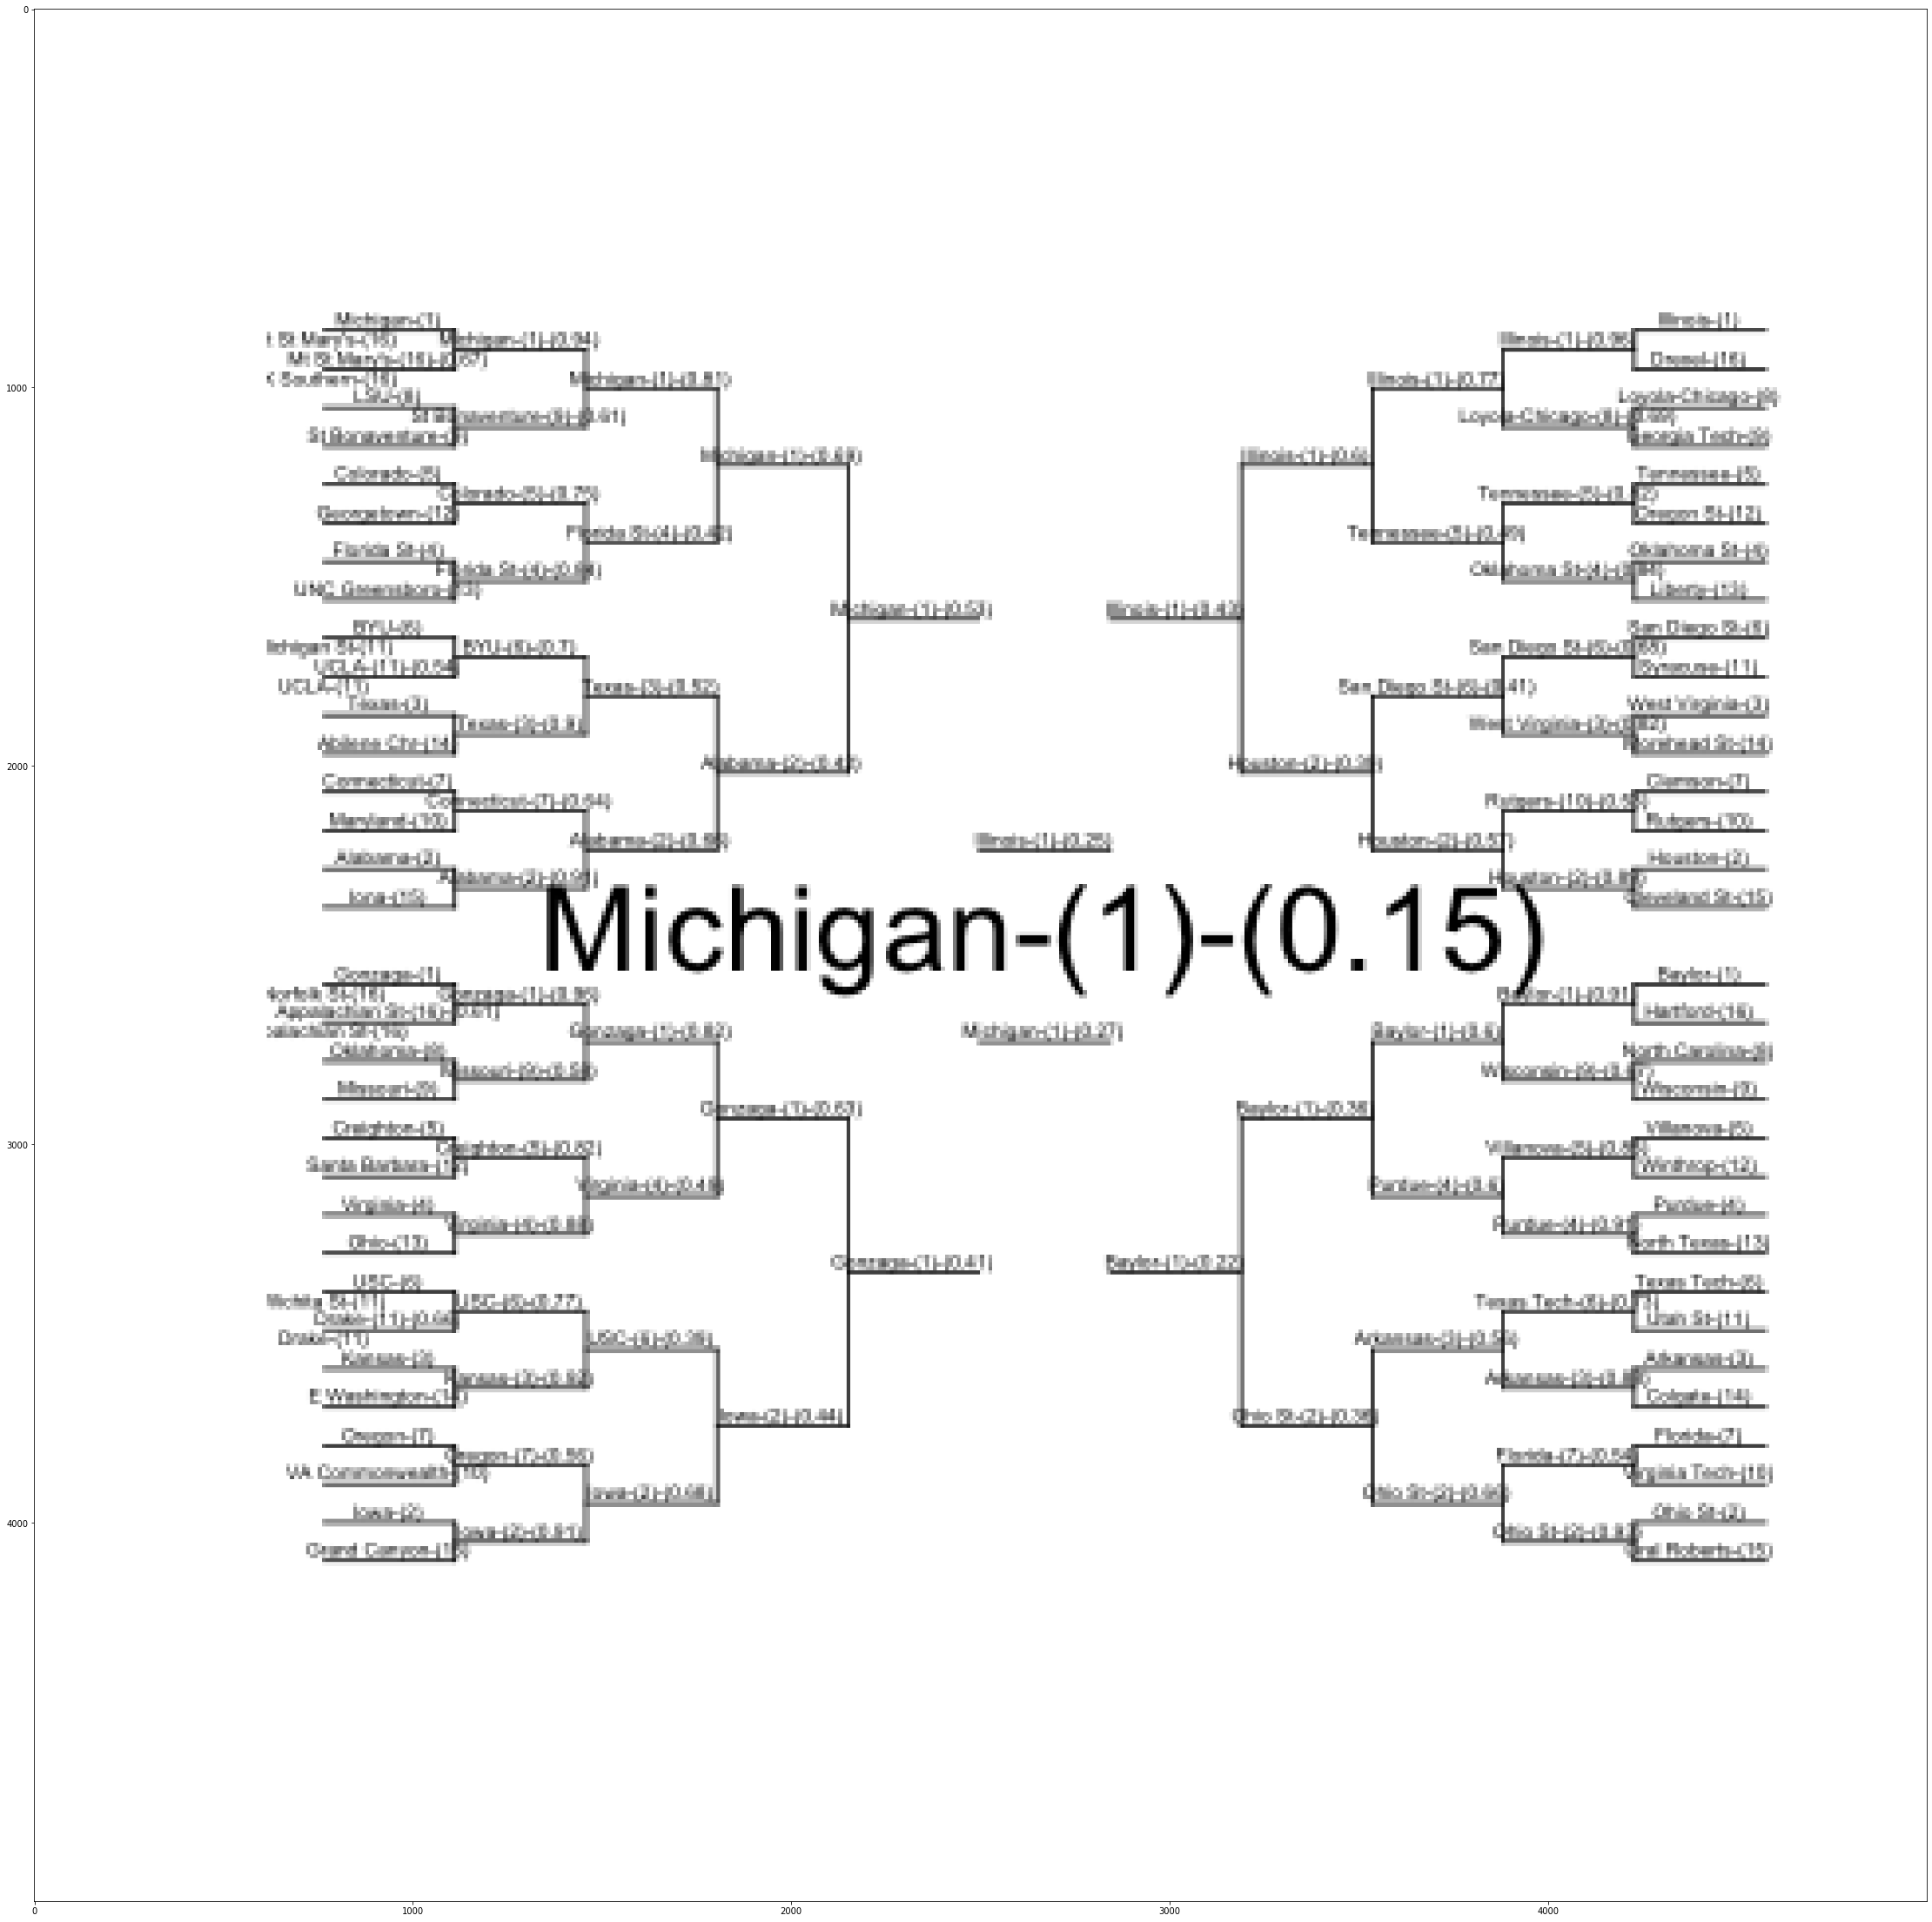

In [246]:
# Loading png and reshaping and displaying in Note book
im = cv2.imread('outputs/bracket_results.png')
im_resized = cv2.resize(im, (5000, 5000), interpolation=cv2.INTER_AREA)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

Apologies for the crappy image, I couldn't find a good way to make the picture pretty in Jupyter. Look at the attached PDF (warning: its all chalk).

## Conclusion

The model generated strong results for past touraments (strong accuarcy score, low log loss). However, we can't measure overfit effectively because we don't have the performance of the test set. If I had more time I would split the historical data into a train and test set to help reduce the overfit possiblity, however I wanted to submit my predictions before the tourament started. 

In the end the model predicted very closely to the actual tournament seeds. This is not suprising because many of the same inputs that the tourament takes into consideration when seeding is similar to the input used in this model prediction. This model is what they call in the bracket industry CHALK! There are only a few upsets, and it predicts an all 1 seed final four. However, Michigan is predicted to win it all when they are ranked as the 4th overall number 1 seed. Please do not use this model as betting advice, especially because the data I used does not take into account the injury of Isaiah livers. 